# Adaptive CMA-ES configurations - Analysis

This Python Notebook covers the analysis of pre-processed data for the adaptive CMA-ES research.

The input data consists of CSVs with the _steepnesses_ of each pre-specified 'section' for all runs, separated into files for each function/dimensionality pair. For details on the pre-processing that went into creating this data, please refer to the `pre-processing.ipynb/html` notebook.

The most important information about the data is that the `steepness` is calculated as $\dfrac{1}{\delta_e}$, where $\delta_e$ is the number of evaluations between 'entering' and 'leaving' the specified section of fitness values.

An example with section boundaries 100, 1 and 0.01:

`idx |   1   2   3 ...   56   57   58   59 ...    164    165    166    167`<br>
`val | 124 102  94 ... 1.13 1.06 0.98 0.96 ... 0.0123 0.0109 0.0098 0.0097`

For section `$\inf$-100`, the first index where the value is _below_ 100 is 3. The steepness is then $\frac{1}{3-0} = 0.33\ldots$. For the next section (boundary 1), the index is 58, giving a steepness of $\frac{1}{58-3} = 0.01818\ldots$, and for the final section the first index is 166 for a steepness of $\frac{1}{166-58} = 0.00925\ldots$.

Because the steepness is calculated as $\frac{1}{\delta_e}$, higher values are better, meaning we can easily discard zeros as sections that were either skipped or never reached at all.


> Sander van Rijn<br>
> s.j.van.rijn@liacs.leidenuniv.nl<br>
> LIACS<br>
> 2018-03-01

## Initialization

In [1]:
%matplotlib inline

from __future__ import division, print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter

In [2]:
# Some utility functions for dealing with the representations

# First, some hardcoded variables
num_options_per_module = [2]*9        # Binary part
num_options_per_module.extend([3]*2)  # Ternary part
max_length = 11
factors = [2304, 1152, 576, 288, 144, 72, 36, 18, 9, 3, 1]

def list_all_representations():
    """ Create a list of all possible representations for the modular CMA-ES.
        Each representation is itself a list with <max_length> integer entries {0, 1, ..., n},
        where 'n' is the number of options for the module in that position.
    """
    products = []
    # count how often there is a choice of x options
    counts = Counter(num_options_per_module)
    for num, count in sorted(counts.items(), key=lambda x: x[0]):
        products.append(product(range(num), repeat=count))
    all_representations = []
    for representation in list(product(*products)):
        all_representations.append(list(sum(representation, ())))
    return all_representations


def reprToString(representation):
    """ Function that converts the structure parameters of a given ES-structure representation to a string

        >>> reprToInt([0,0,0,0,0,1,0,1,0,1,0])
        >>> '00000101010'
    """
    return ''.join([str(i) for i in representation[:max_length]])

In [3]:
data_location = './data/'
file_name = 'steepness_data_{ndim}D-f{fid}.csv'

#TODO: Retrieve this information from the files instead?
ndims = [5, 20]
fids = [1, 10, 15, 20]
steepness_sections = [1e2, 1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

# Exploration
Using the data in (one of) the CSV files, we'll start with some exploratory analysis.
Any useful procedures will be coded as functions, making them easy to re-use for a final full analysis later on.

In [4]:
def get_data(ndim, fid):
    return pd.read_csv(data_location + file_name.format(ndim=ndim, fid=fid), index_col=0)

# Starting with 20D F15 as an example
df = get_data(ndim=20, fid=15)
df.head()

,Representation,ndim,function ID,instance ID,repetition,100.0,10.0,1,0.1,0.01,0.001,0.0001,1e-05,1e-06,1e-07,1e-08
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",20,15,0,0,0.000277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",20,15,0,1,0.000362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",20,15,0,2,0.000403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",20,15,0,3,0.000413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",20,15,0,4,0.000445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def aggregateByMean(df):
    df_means = df.groupby(by=['Representation', 'ndim', 'function ID']).mean()
    df_means = df_means.drop(columns=['instance ID', 'repetition'])
    df_means = df_means.reset_index()
    return df_means

def aggregateByStd(df):
    df_std = df.groupby(by=['Representation', 'ndim', 'function ID']).std()
    df_std = df_std.drop(columns=['instance ID', 'repetition'])
    df_std = df_std.reset_index()
    return df_std

In [6]:
df_means = aggregateByMean(df)
df_means.head()

,Representation,ndim,function ID,100.0,10.0,1,0.1,0.01,0.001,0.0001,1e-05,1e-06,1e-07,1e-08
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",20,15,0.000370,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",20,15,0.000400,0.000016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]",20,15,0.000389,0.000007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",20,15,0.000535,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]",20,15,0.000555,0.000117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
def getInterestingIndices(df, nlargest=5):
    indices = set()
    for col in df.columns[3:]:
        if df[col].max() > 0:
            new_indices = set(df[col].nlargest(nlargest).axes[0])
            indices = indices.union(new_indices)

    return indices

In [8]:
section_labels = ['\inf - {}'.format(steepness_sections[0])]
section_labels.extend(['{} - {}'.format(a, b) for a, b in zip(steepness_sections[:-1], steepness_sections[1:])])

def plotOnAxis(df, ax, *, nlargest=5, title=None, legend=True):
    for idx in getInterestingIndices(df, nlargest):
        record = df.iloc[idx]
        ax.plot(record[3:].values, '-o', label=record['Representation'])

    ax.set_ylabel("\'steepness\'")
    ax.set_xlabel('convergence sections')
    ax.set_xticks(np.arange(len(steepness_sections)))
    ax.set_xticklabels(section_labels)
    ax.xaxis.set_tick_params(rotation=90)
    if title:
        ax.set_title(title)
    if legend:
        ax.legend(loc=0)

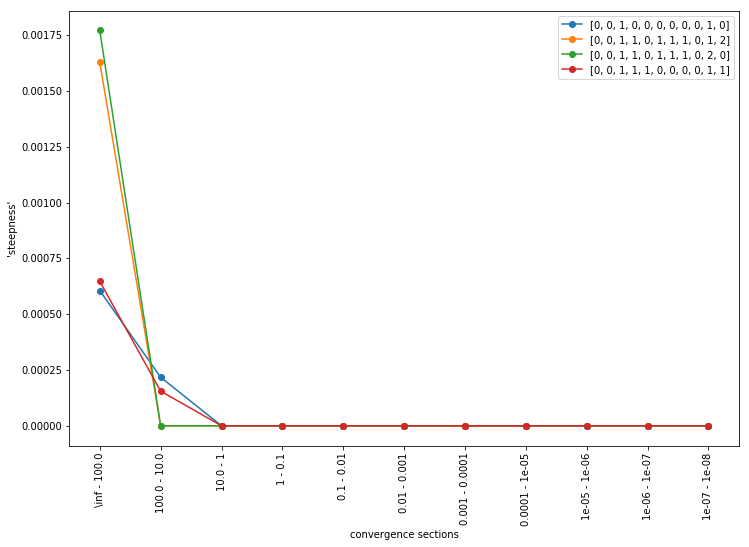

In [9]:
# Let's plot the currently loaded data as an example
fig, ax = plt.subplots(figsize=(12,8))
plotOnAxis(df_means, ax, nlargest=2)
plt.show()

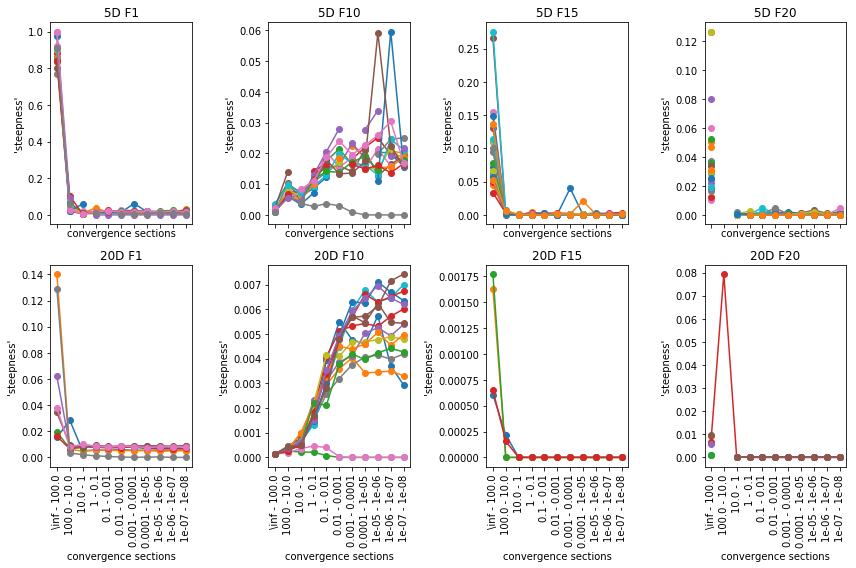

In [10]:
# Because it's defined as a simple-to-use function, we can now plot this data for all available datasets
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12,8), sharex=True)

for exp, ax in zip(product(ndims, fids), axes.flatten()):
    ndim, fid = exp
    df_means = aggregateByMean(get_data(ndim=ndim, fid=fid))
    plotOnAxis(df_means, ax, nlargest=2, title='{}D F{}'.format(ndim, fid), legend=False)

plt.tight_layout()
plt.show()

In [11]:
def calcSumOfInverses(df, columns):
    sum_of_invs = pd.Series(data=0, index=df.index)
    for col in columns:
        nonzeros = df[col] > 0
        invs = 1/df[col][nonzeros]
        if len(invs > 0):
            sum_of_invs = sum_of_invs.add(invs, fill_value=0)
    return sum_of_invs

calcSumOfInverses(df_means, df_means.columns[3:]).head()

0     950.660192
1     969.220261
2    1064.206511
3     918.398713
4     969.015872
dtype: float64

In [12]:
def getConfigsThatReachedLastSection(df, columns):
    for col in reversed(columns):
        nonzero_indices = df[col] > 0
        if len(df[nonzero_indices]) != 0:
            return nonzero_indices

getConfigsThatReachedLastSection(df_means, df_means.columns[3:]).head()

0    False
1    False
2    False
3    False
4    False
Name: 1, dtype: bool

In [13]:
nonzero_indices = getConfigsThatReachedLastSection(df_means, df_means.columns[3:])
expected_runtimes = calcSumOfInverses(df_means[nonzero_indices], df_means.columns[3:])
expected_runtimes.sort_values()[:5]

1569     8236.612246
3302    11324.738181
4598    12086.056329
3595    13055.764006
3750    14233.545053
dtype: float64

In [14]:
def calcTheoreticalBest(df, columns):
    best = 0
    for col in columns:
        df_col = df[col].replace(np.inf, np.nan).dropna()
        col_max = df_col.max()
        if col_max != 0 and not np.isnan(col_max):
            best += 1/col_max
    return best

calcTheoreticalBest(df_means, df_means.columns[3:])

8183.9267640786638

In [15]:
records = []
labels = ['ndim', 'fid', 'Empirical best', 'Adaptive best', 'Relative improvement']
for ndim, fid in product(ndims, fids):
    df_means = aggregateByMean(get_data(ndim=ndim, fid=fid))
    columns = df_means.columns[3:]
    
    nonzero_indices = getConfigsThatReachedLastSection(df_means, columns)
    actual_best = calcSumOfInverses(df_means[nonzero_indices], columns).min()
    
    theory_best = calcTheoreticalBest(df_means, columns)
    
    rel_improvement = 1-(theory_best/actual_best)
    
    records.append((ndim, fid, actual_best, theory_best, rel_improvement))
    
results = pd.DataFrame.from_records(records, columns=labels)
print(results)

   ndim  fid  Empirical best  Adaptive best  Relative improvement
0     5    1      196.149640     108.255803              0.448096
1     5   10      831.331927     425.403190              0.488287
2     5   15     3211.435751     779.556093              0.757256
3     5   20    11266.106685    2556.762990              0.773057
4    20    1     1179.149963    1047.688689              0.111488
5    20   10    12964.580087   11880.638199              0.083608
6    20   15     6244.717538    5159.823487              0.173730
7    20   20     8236.612246    8183.926764              0.006396
